# Optimization using the ProblemInterface class

This notebook will show the basics of setting up a resilience optimization problem with the `Problem` class in `fmdtools.sim.search` module.

In [1]:
from fmdtools.sim.search import ProblemInterface
from fmdtools.define.approach import SampleApproach
from matplotlib import pyplot as plt
import fmdtools.analyze as rd
from pump_stochastic import Pump

### ProblemInterface Setup
The `ProblemInterface` class can be used to define an optimization problem around and fmdtools model/simulation in terms of variables, objectives, and constraints. See below:

In [2]:
print(ProblemInterface.__doc__)


    Interfaces for resilience optimization problems. 
    
    Attributes
    ----------
        simulations : dict
            Dictionary of simulations and their corresponding arguments
        variables : list
            List of variables and their properties
        objectives : dict
            Dictionary of objectives and their times/arguments
        constraints : dict
            Dictionary of constraints and their times/arguments
        current_iter : dict
            Dictionary of current values for variables/objectives/constraints/etc.
    


The problem class has many of the same objects as the methods in the `sim.propagate` module:

In [3]:
help(ProblemInterface.__init__)

Help on function __init__ in module fmdtools.sim.search:

__init__(self, name, mdl, default_params={}, negative_form=True, log_iter_hist=False, **kwargs)
    Instantiates the Problem object.
    
    Parameters
    ----------
    
    name : str
        Name for the problem
    mdl : Model
        Model to optimize
    negative_form : bool
        Whether constraints are negative when feasible (True) or positive when feasible (False)
    default_params : dict
        Default parameters for the model
    **kwargs : kwargs
        Default run kwargs. See :data:`sim_kwargs`, :data:`run_kwargs`, :data:`mult_kwargs`



Below we send the pump model and specify to simulate it using the `staged` option (which should be much faster to iterate over).

In [4]:
mdl=Pump()
new_problem = ProblemInterface("new_problem", mdl, staged=True, negative_form=False)

Next, a simulation is added to the `Problem` using `Problem.add_simulation`

In [5]:
help(ProblemInterface.add_simulation)

Help on function add_simulation in module fmdtools.sim.search:

add_simulation(self, simname, simtype, *args, **kwargs)
    Defines a simulation to be used with the model
    
    Parameters
    ----------
    simname : str
        Name/identifier for the simulation.
    simtype : str, optional
        Type of simulation(s) to run (aligns with propagate methods):
            - single:      simulates a single scenario (the default)
                - args: sequence: sequence defining fault scenario {time:{'faults':(fxn:mode), 'disturbances':{'Fxn1.var1'}})}
            - multi:       simulates multiple scenarios (provided approach or nominalapproach)
                - args: scenlist: dict with structure {"scenname":{'sequence':{"faults":{}, "disturbances":{}}, "properties":{"params":params}}}
                        (can be gotten from prop.list_init_faults, SampleApproach, or NominalApproach)
            - nested:      simulates nested scenarios (provided approach and nominalapproach)
 

In this case, we will optimize over a single scenario, passing ``single`` as the simtype.

In [6]:
new_problem.add_simulation("test_sim","single", sequence={20:{"faults":{"ImportEE": "no_v"}}})

Variables may then be added using `Problem.add_variables`. 

In [7]:
help(ProblemInterface.add_variables)

Help on function add_variables in module fmdtools.sim.search:

add_variables(self, simnames, *args, vartype='vars', t=0)
    Adds variable of specified type ('params', 'vars', or 'faults') to a given problem. 
    Also adds variable set constraints (if given)
    
    Parameters
    ----------
    simnames : str/list
        identifier for the simulation(s) the variable is optimized over
    *args : tuples
        variables to add, where each tuple has the form:
        (varname, set_const (optional), vartype (optional), t (optional)), where
        - varname is:
            an element of mdl.params (if vartype='params')
            a model variable (if vartype='vars')
            a function name (if vartype='faults')
        - set_const defines the variable set constraints, which may be:
            None (for none/inf)
            A two-element tuple (for continuous variable bounds)
            A multi-element list (for discrete variables)
        - vartype is the individual variable 

In this case, we are optimizing a change in the `eff` parameter at time t=10. Note that using the `staged` option, this means that the model will be copied at this time and then simulated to the final simulation time.

This variable is also given the set constraint (bounds) of [0,5], which will show up in the `constraints` dictionary.

In [8]:
new_problem.add_variables("test_sim", ("MoveWater.eff", [0,5]), t=10)

We can further add objectives using `Problem.add_objectives`

In [9]:
help(ProblemInterface.add_objectives)

Help on function add_objectives in module fmdtools.sim.search:

add_objectives(self, simname, *args, objtype='endclass', t='end', obj_const='objectives', agg=('+', 'sum'), **kwargs)
    Adds objective to the given problem.
    
    Parameters
    ----------
    simname : str
        identifier for the simulation
    *args : strs/tuples
        variables to use as objectives (auto-named to f1, f2...)
        may take form: (variablename, objtype (optional), t (optional), agg (optional)) 
        or variablename, where variablename is the name of the variable (from params, mdlparams)
        or index of the callable (for external)and objtype, t, and agg may override
        the default objtype and t (see below)
    objtype : str (optional)
        default type of objective: `vars`, `endclass`, or `external`. Default is 'endclass'
    t : int (optional)
        default time to get objective: 'end' or set time t
    agg : tuple
        Specifies the aggregation of the objective/constraint:

In this case, we are optimizing the total flow in the `MoveWater` function as read at time t=25. 

In [10]:
new_problem.add_objectives("test_sim", obj_1="MoveWater.total_flow", objtype='vars', t=25)

We can additionally add constraints to the problem, in this case power as read at t=25.

In [11]:
new_problem.add_constraints("test_sim", con_1 = "Wat_1.pressure", objtype='vars', t=11, threshold = ('less', 20))

Note that if all objectives and constraints are sampled in time before the defined simulation end-point, it will finish before completion to save computational time.


In [12]:
new_problem

Problem new_problem                                                     current value
 Variables
 -vars MoveWater.eff at t=10: [0, 5]                                              nan
 Objectives
 -obj_1: +sum(test_sim vars MoveWater.total_flow at t=25)                         nan
 Constraints
 -con_1: -(test_sim vars Wat_1.pressure at t=11 -20)                              nan
 Simulations
 -test_sim: single scen: {20: {'faults': {'ImportEE': 'no_v'}}}

The string representation of the problem shows how the objectives/constraints have been set up, that reflects:
- the form of the objectives as positive or negative for maximization/minimization (set with the `agg` parameter in `add_objectives`).
- the form of the constraints as positive or negative based on the `threshold` parameter in `add_constraints` and overall `negative_form` setting.

These parameters will need to be adjusted depending on whether the interfacing optimization package is set up for minimization or maximization or in positive or negative null form (where feasible means positive or negative constraint values).

### Problem interfaces
Now that this problem is set up, we now have interfaces which can be passed to optimization methods. These are methods which *match the names of the objectives/constraints defined earlier* which can be passed as callables to optimizaiton methods.

In [13]:
new_problem.obj_1([3])

10.500000000000002

Note that despite being different callables, to reduce simulation costs, `obj_1` and `con_1` only *simulate the model* when a new variable value is entered into the problem. This can be seen by looking at the `current_iter` __repr__, which shows the values of the objectives/constraints a the current variable value.

In [14]:
new_problem

Problem new_problem                                                     current value
 Variables
 -vars MoveWater.eff at t=10: [0, 5]                                           3.0000
 Objectives
 -obj_1: +sum(test_sim vars MoveWater.total_flow at t=25)                     10.5000
 Constraints
 -con_1: -(test_sim vars Wat_1.pressure at t=11 -20)                         -10.0000
 Simulations
 -test_sim: single scen: {20: {'faults': {'ImportEE': 'no_v'}}}

Additionally, provided the tracking options are set to on, the `plot_obj_const` method enables rapid visualization of objectives, constraints, and variables (and where they are queried):

(<Figure size 432x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Wat_1: pressure'}>,
        <AxesSubplot:title={'center':'MoveWater: total_flow'}>,
        <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>,
        <AxesSubplot:>], dtype=object))

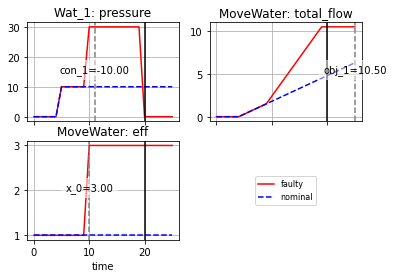

In [15]:
new_problem.plot_obj_const('test_sim')

### Optimization:
Now, we will demonstrate optimization using this problem as it is set up:

In [16]:
from scipy.optimize import minimize

In [17]:
new_problem.current_iter

{'vars': array([3]),
 'objs': {'obj_1': 10.500000000000002},
 'consts': {'con_1': -10.0},
 'sims': {'test_sim'},
 'sims_to_update': {'set_const'}}

In [18]:
constraints=new_problem.get_constraint_list()

In [19]:
constraints[0]['fun']([8])

8

Note that scipy minimize assumes that:
- objectives are to be minimized, and
- constraints must be held positive 

The problem should thus be set up to accomodate this, by stating whether objectives should be positive/negative and by setting `negative_form=False`.

In [20]:
res = minimize(new_problem.obj_1, [1], constraints=new_problem.get_constraint_list())

In [21]:
res

     fun: 1.4999999999999978
     jac: array([2.99999997])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-8.8817842e-16])

As shown, the variables are optimized to a value of x=0.0, the minimum possible value of MoveWater.eff which was put in the problem. We can further verify the optimized result by looking at the problem:

In [22]:
new_problem

Problem new_problem                                                     current value
 Variables
 -vars MoveWater.eff at t=10: [0, 5]                                           0.0000
 Objectives
 -obj_1: +sum(test_sim vars MoveWater.total_flow at t=25)                      1.5000
 Constraints
 -con_1: -(test_sim vars Wat_1.pressure at t=11 -20)                          20.0000
 Simulations
 -test_sim: single scen: {20: {'faults': {'ImportEE': 'no_v'}}}

As shown, the bound set constraint x>0 is active at the found minimum, as we would expect.

We can further visualize this solution using:

(<Figure size 432x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Wat_1: pressure'}>,
        <AxesSubplot:title={'center':'MoveWater: total_flow'}>,
        <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>,
        <AxesSubplot:>], dtype=object))

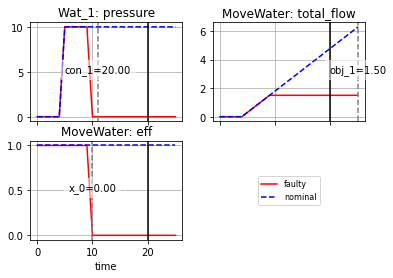

In [23]:
new_problem.plot_obj_const('test_sim')

This result for this minimization is somewhat obvious. Alternatively, it may be interesting to see what would happen if we instead maximized the objective (as in, searched for the `eff` value that maximized total flow despite constraints/fault modes).

In [24]:
mdl=Pump()
problem_2 = ProblemInterface("new_problem", mdl, staged=True, negative_form=False)
problem_2.add_variables("test_sim", ("MoveWater.eff", [0,5]), t=10)
problem_2.add_simulation("test_sim","single", sequence={20:{"faults":{"ImportEE": "no_v"}}})
problem_2.add_objectives("test_sim", obj_1="MoveWater.total_flow", objtype='vars', t=25, agg=("-", "sum"))
problem_2.add_constraints("test_sim", con_1 = "Wat_1.pressure", objtype='vars', t=11, threshold = ('less', 20))

In [25]:
problem_2

Problem new_problem                                                     current value
 Variables
 -vars MoveWater.eff at t=10: [0, 5]                                              nan
 Objectives
 -obj_1: -sum(test_sim vars MoveWater.total_flow at t=25)                         nan
 Constraints
 -con_1: -(test_sim vars Wat_1.pressure at t=11 -20)                              nan
 Simulations
 -test_sim: single scen: {20: {'faults': {'ImportEE': 'no_v'}}}

In [26]:
problem_2.con_1([1])

10.0

In [27]:
problem_2.x_to_obj_const([1], "set_const")

({'obj_1': -4.499999999999999},
 {'con_1': 10.0, 'set_var_0_ub': 4, 'set_var_0_lb': 1})

In [28]:
res = minimize(problem_2.obj_1, [1], constraints=problem_2.get_constraint_list())

In [29]:
res

     fun: -7.4999999999999964
     jac: array([-3.00000012])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([2.])

In [30]:
problem_2

Problem new_problem                                                     current value
 Variables
 -vars MoveWater.eff at t=10: [0, 5]                                           2.0000
 Objectives
 -obj_1: -sum(test_sim vars MoveWater.total_flow at t=25)                     -7.5000
 Constraints
 -con_1: -(test_sim vars Wat_1.pressure at t=11 -20)                          -0.0000
 Simulations
 -test_sim: single scen: {20: {'faults': {'ImportEE': 'no_v'}}}

As shown, the constraint `con_1` is active, meaning the optimal presure at `t=11` is just at the threshold of 20. This corresponds to the optimized `MoveWater.eff` value of 2.0.

We can see this below:

(<Figure size 432x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Wat_1: pressure'}>,
        <AxesSubplot:title={'center':'MoveWater: total_flow'}>,
        <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>,
        <AxesSubplot:>], dtype=object))

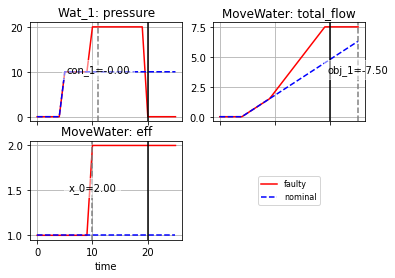

In [31]:
problem_2.plot_obj_const('test_sim')

### Multi-scenario Optimization

In addition to optimizing over single-scenarios `Problem` can be used to optimize over lists of scenarios from an `SampleApproach` or `NominalApproach`.

Here we define a slightly different problem, where instead of optimizing variable changes at specific times (e.g., faults), we instead optimize the model parameter `delay`, which changes how long of a delay there is before a fault when there is adverse pressure.

To see the effect of this accross scenarios, we first define an approach:

In [32]:
app = SampleApproach(mdl, faults="ExportWater", phases=["on"], defaultsamp={'samp':'evenspacing','numpts':4})

In [33]:
app

SampleApproach for Pump model with 1 modes: 
 -ExportWater: block
None joint modes (0 combinations), 
in 1 phases: 
 -('global', 'on'): [5, 49] 
sampled at 4 times: 
 -[14, 23, 31, 40]
resulting in 4 total fault scenarios.

The scenlist from this approach is given to the same model.

In [34]:
multi_problem = ProblemInterface("multi_problem", mdl, negative_form=False) #, track='valparams')
multi_problem.add_simulation("test_multi", "multi", app.scenlist)

Next the delay parameter is added. Note that since this a model parameter (set at the beginning of the simulation), `vartype` is set to "param".

In [35]:
multi_problem.add_variables("test_multi", ("delay", [0,45]), vartype='param')

Our objective for this problem will be to minimize the cost model overall scenarios that is defined in `mdl.find_classification`. Note that this means `objtype` must be set to "endclass", since the objective will be a value of the endclass dictionary corresponding to the key "expected cost".

In [36]:
multi_problem.add_objectives("test_multi", cost="expected cost", objtype='endclass')

We can then verify the problem setup. Note that no constraints will be used in this problem:

In [37]:
multi_problem

Problem multi_problem                                                   current value
 Variables
 -param delay at t=0: [0, 45]                                                     nan
 Objectives
 -cost: +sum(test_multi endclass expected cost at t=end)                          nan
 Constraints
 -
 Simulations
 -test_multi: multi scen: 

We may now minimize the objective function:

In [38]:
res = minimize(multi_problem.cost, [5], method="SLSQP", bounds=[[0,40]])

In [39]:
res = minimize(multi_problem.cost, [5], method="nelder-mead")

In [40]:
res

 final_simplex: (array([[5.        ],
       [5.00006104]]), array([682267.5, 682267.5]))
           fun: 682267.5000000001
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 13
        status: 0
       success: True
             x: array([5.])

Interestingly enough, while the optimizer gives a "optimization terminated successfully," it stays at the initial point. This may be because of a poor fit of oftimization method. See:

In [41]:
objs = [multi_problem.cost([i]) for i in range(100)]

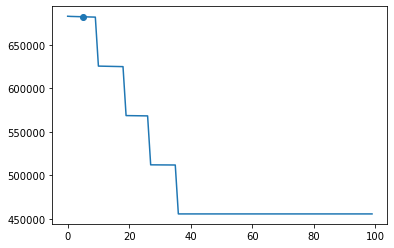

In [42]:
plt.plot(objs)
plt.scatter(res.x, res.fun)

As shown, the objective appears to be non-differentiable, with several plateaus between the starting point (20) and the minimum. Since the `SLSQP` solver is a gradient-based solver, it probably sees the gradient as 0 at this point, making it think the result is already an optimum. 

While many different optimization packages exist, one of the more-developed ones is the `pymoo` package ([see reference](https://pymoo.org/)). Below we show how to interface with `pymoo` to use a solver that will find the optimal solution.

In [43]:
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
import numpy as np

The method `.to_pymoo_problem()` sets up a [pymoo problem object](https://pymoo.org/interface/problem.html) which can be used with a pymoo algorithm per the documentation. Note that this object corresponds directly (that is, is linked) to the original problem (see below).

In [44]:
pymoo_prob = multi_problem.to_pymoo_problem()

In [45]:
algorithm=PatternSearch(x0=np.array([5])) 

In [46]:
res = minimize(pymoo_prob, algorithm, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  6.822675E+05 |  6.822675E+05
     2 |        2 |  6.539020E+05 |  6.255366E+05
     3 |        4 |  5.970572E+05 |  5.685778E+05
     4 |        6 |  5.120620E+05 |  4.555462E+05
     5 |        9 |  4.555462E+05 |  4.555462E+05
     6 |       11 |  4.555462E+05 |  4.555462E+05
     7 |       13 |  4.555462E+05 |  4.555462E+05
     8 |       15 |  4.555462E+05 |  4.555462E+05
     9 |       17 |  4.555462E+05 |  4.555462E+05
    10 |       19 |  4.555462E+05 |  4.555462E+05
    11 |       21 |  4.555462E+05 |  4.555462E+05
    12 |       23 |  4.555462E+05 |  4.555462E+05
    13 |       25 |  4.555462E+05 |  4.555462E+05
    14 |       27 |  4.555462E+05 |  4.555462E+05


In [47]:
res.X

array([36.875])

In [48]:
res.F

array([455546.25])

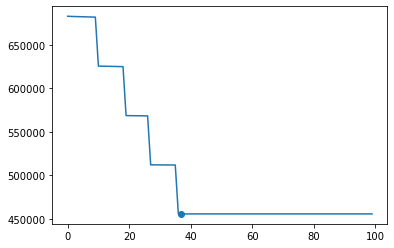

In [49]:
plt.plot(objs)
plt.scatter(res.X, res.F)

As shown, this method more capably finds the minimum in this case, in part because the underlying search algorithm (Hooke and Jeeves Pattern Search) is more robust to this type of problem.

We can visualize the results of this problem by looking at the simulation log:

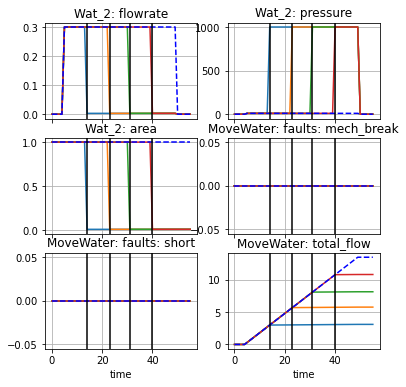

In [50]:
fig, ax = rd.plot.mdlhists(multi_problem._sims['test_multi']['mdlhists'],\
              fxnflowvals={"MoveWater":['total_flow', "faults"], "Wat_2":{"area", 'flowrate', 'pressure'}},\
              time_slice=app.times, legend_loc=False)

Compare this with the response at the initial value:

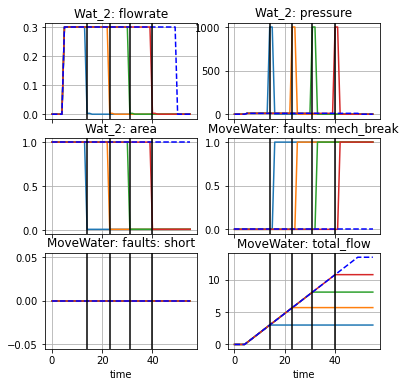

In [51]:
multi_problem.cost([1])
fig, ax = rd.plot.mdlhists(multi_problem._sims['test_multi']['mdlhists'],\
              fxnflowvals={"MoveWater":['total_flow', "faults"], "Wat_2":{"area", 'flowrate', 'pressure'}},\
              time_slice=app.times, legend_loc=False)

As shown, the main difference is that at the initial point, the short delay causes the pump to during the time of the simulation, while at a long delay, the pump breaks later in the simulation. The optimum is at t=37 since this is the first point where all four scenarios no longer result in a mechanical break of the pump.